In [2]:
__author__ = 'ORI'

from matplotlib.collections import LineCollection

import numpy as np
import scipy.io
import sys, os
import matplotlib.pyplot as plt
# I should learn how to load libraries in a more elegant way



sys.path.append(r'C:\Users\ORI\Documents\IDC-non-sync\Thesis\PythonApplication1\OriKerasExtension')
#import OriKerasExtension
import ThesisHelper
#reload(OriKerasExtension)
reload(ThesisHelper)
from   ThesisHelper import LoadSingleSubjectPython, readCompleteMatFile, ExtractDataVer4
import P300Prediction
reload(P300Prediction)
from P300Prediction import accuracy_by_repetition, create_target_table


sys.path.append(r'C:\Users\ORI\Documents\IDC-non-sync\Thesis\PythonApplication1\OriKerasExtension')
#import OriKerasExtension
import ThesisHelper
from sklearn.metrics import roc_curve, auc, roc_auc_score
import P300Prediction
from keras.layers.recurrent import LSTM
from keras.callbacks import ModelCheckpoint
from keras.utils.np_utils import to_categorical
from scipy import stats
from sklearn.cross_validation import StratifiedShuffleSplit

#reload(OriKerasExtension)
reload(ThesisHelper)
from ThesisHelper import LoadSingleSubjectPython, readCompleteMatFile, ExtractDataVer4
from sklearn.utils import shuffle
from sklearn.cross_validation import train_test_split

reload(P300Prediction)
from P300Prediction import accuracy_by_repetition, create_target_table


# [all_target, all_non_target] = LoadSingleSubjectPython(r'C:\Users\ORI\Documents\Thesis\dataset_all\RSVP_Color116msVPfat.mat')



# all_samples = np.vstack((all_target,all_non_target))


# '''
# Create the tagging column
# '''
# all_tags = np.vstack((np.ones((all_target.shape[0],1)), np.zeros((all_non_target.shape[0],1))))



# from OriKerasExtension.OriKerasExtension import DebugLSTM
import keras
from keras.models import Sequential
from keras.layers.recurrent import LSTM
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.regularizers import l2
from  keras.regularizers import WeightRegularizer

'''
define the neural network model:
'''


def create_compile_cnn_model():
    model = Sequential()

    number_of_time_stamps = 20
    number_of_out_channels = 10
    number_of_in_channels = 55
    length_of_time_axe_mask = 10

    model.add(Convolution2D(nb_filter=10,
                            nb_col=number_of_out_channels,
                            nb_row=1,
                            input_shape=(1, number_of_time_stamps, number_of_in_channels),
                            border_mode='same',
                            init='glorot_normal'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(1, number_of_in_channels)))
    model.add(
        Convolution2D(nb_filter=number_of_out_channels, nb_row=6, nb_col=1, border_mode='same', init='glorot_normal'))
    model.add(MaxPooling2D(pool_size=(20, 1)))
    model.add(Activation('relu'))
    model.add(Flatten())
    model.add(Dense(100))
    model.add(Activation('relu'))
    model.add(Dense(2))
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='sgd')
    return model

def create_compile_lstm_model():

    '''
    define the neural network model:
    '''
    model_lstm = Sequential()

    model_lstm.add(LSTM(input_dim=55, output_dim=20,return_sequences=True))
    model_lstm.add(Dropout(0.3))
    model_lstm.add(LSTM(input_dim=20, output_dim=20,return_sequences=False))
    model_lstm.add(Dense(2, W_regularizer=l2(0.06)))
    model_lstm.add(Activation('softmax'))
    model_lstm.compile(loss='categorical_crossentropy', optimizer='rmsprop')

    return model_lstm


def create_compile_dense_model():

    '''
    define the neural network model:
    '''
    model_lstm = Sequential()
    model_lstm.add(keras.layers.core.Flatten(input_shape=(55,100)))
    model_lstm.add(Dense(input_dim=55*100, output_dim=30 , W_regularizer=l2(0.06)))
    model_lstm.add(Activation('tanh'))
    model_lstm.add(Dense(2))
    model_lstm.add(Activation('softmax'))
    model_lstm.compile(loss='categorical_crossentropy', optimizer='rmsprop')

    return model_lstm

def create_small_compile_dense_model():

    '''
    define the neural network model:
    '''
    model_lstm = Sequential()
    model_lstm.add(keras.layers.core.Flatten(input_shape=(55,25)))
    model_lstm.add(Dense(input_dim=55*25, output_dim=20 ))
    model_lstm.add(Dropout(0.3))
    model_lstm.add(Activation('tanh'))
    model_lstm.add(Dense(output_dim=20 , W_regularizer=l2(0.06)))
    model_lstm.add(Activation('tanh'))
    model_lstm.add(Dense(2))
    model_lstm.add(Activation('softmax'))
    model_lstm.compile(loss='categorical_crossentropy', optimizer='rmsprop')

    return model_lstm


# def down_sample_data()




Using Theano backend.
Using gpu device 0: GeForce GT 740M (CNMeM is disabled, CuDNN not available)
C:\Anaconda\lib\site-packages\theano\tensor\signal\downsample.py:5: UserWarning: downsample module has been moved to the pool module.
  warnings.warn("downsample module has been moved to the pool module.")


In [3]:
def create_evaluation_data(gcd_res, down_samples_param):
#     gcd_res = readCompleteMatFile(file_name)
    data_for_eval = ExtractDataVer4(gcd_res['all_relevant_channels'], gcd_res['marker_positions'], gcd_res['target'],
                                    -200, 800)
    # print  data_for_eval

    temp_data_for_eval = downsample_data(data_for_eval[0], data_for_eval[0].shape[1], down_samples_param)

    test_data_gcd, test_target_gcd = temp_data_for_eval[gcd_res['train_mode'] != 1], data_for_eval[1][
        gcd_res['train_mode'] != 1]
    return test_data_gcd, test_target_gcd


def downsample_data(data, number_of_original_samples, down_samples_param):


    new_number_of_time_stamps = number_of_original_samples / down_samples_param


    # print  data_for_eval
    temp_data_for_eval = np.zeros((data.shape[0], new_number_of_time_stamps, data.shape[2]))

    for new_i, i in enumerate(range(0, number_of_original_samples, down_samples_param)):
        temp_data_for_eval[:, new_i, :] = np.mean(data[:, range(i, (i + down_samples_param)), :], axis=1)
    return temp_data_for_eval


def create_train_data(gcd_res, down_samples_param):
    all_positive_train = []
    all_negative_train = []

    last_time_stamp = 800
    fist_time_stamp = -200


    data_for_eval = ExtractDataVer4(gcd_res['all_relevant_channels'], gcd_res['marker_positions'],
                                    gcd_res['target'], fist_time_stamp, last_time_stamp)
    
    print data_for_eval[0].shape
    temp_data_for_eval = downsample_data(data_for_eval[0],data_for_eval[0].shape[1], down_samples_param)

    all_data = temp_data_for_eval[np.all([gcd_res['train_mode'] == 1], axis=0)]
    categorical_tags = to_categorical(gcd_res['target'][gcd_res['train_mode'] == 1])
    indexes = range(len(categorical_tags))
    print "len(categorical_tags) {0}".format(len(categorical_tags))

    shuffeled_samples, suffule_tags = (all_data, categorical_tags)
    return shuffeled_samples, suffule_tags


def create_data_for_compare_by_repetition(file_name):
    gcd_res = readCompleteMatFile(file_name)
    sub_gcd_res = dict(train_trial=gcd_res['train_trial'][gcd_res['train_mode'] != 1],
                       train_block=gcd_res['train_block'][gcd_res['train_mode'] != 1],
                       stimulus=gcd_res['stimulus'][gcd_res['train_mode'] != 1])
    return sub_gcd_res

#shuffeled_samples, suffule_tags = create_train_data(file_name=None, down_samples_param=5)
# shuffeled_samples, suffule_tags = create_train_data(file_name=None, down_samples_param=20)
# original_weights_mlp = model_mlp.get_weights()

data_set_locations = ["RSVP_Color116msVPicr.mat",
                      "RSVP_Color116msVPpia.mat",
                      "RSVP_Color116msVPfat.mat",
                      "RSVP_Color116msVPgcb.mat",
                      "RSVP_Color116msVPgcc.mat",
                      "RSVP_Color116msVPgcd.mat",
                      "RSVP_Color116msVPgcf.mat",
                      "RSVP_Color116msVPgcg.mat",
                      "RSVP_Color116msVPgch.mat",
                      "RSVP_Color116msVPiay.mat",
                      "RSVP_Color116msVPicn.mat"];

# data_set_locations = ["RSVP_Color116msVPgcd.mat"]

# results = []

# for subject_name in data_set_locations:
#     file_name = r'C:\Users\ORI\Documents\Thesis\dataset_all\{0}'.format(subject_name)
#     gcd_res = readCompleteMatFile(file_name)

def print_true_vs_predict(true_val, predicted_val):
    import matplotlib.cm as cm        
    plt.figure(figsize=(20,10))
    plt.subplot(1,2,1)
    plt.imshow(true_val[:,1].reshape(-1,30), cmap=cm.Greys_r, interpolation='none', aspect='auto')
    plt.subplot(1,2,2)
    plt.imshow(predicted_val[:,1].reshape(-1,30), cmap=cm.Greys_r, interpolation='none', aspect='auto')
    plt.show()

# def calculate_proximity_to_target()

In [4]:
gcd_res = readCompleteMatFile(file_name)
target_location = np.where(np.all([gcd_res['train_mode'] == 1,gcd_res['target'] == 1 ], axis = 0))[0]


NameError: name 'file_name' is not defined

In [40]:
non_target_location = np.where(np.all([gcd_res['train_mode'] == 1,gcd_res['target'] == 0 ], axis = 0))[0]
# np.abs(non_target_location - 13).argmin()
print len(target_location)
distance_from_target =  np.zeros((len(target_location), len(non_target_location)))
for i, item in enumerate(target_location) :
    distance_from_target[i,:] = np.abs(non_target_location - item)
print distance_from_target.min(axis=0).astype(np.int)


240
[13 12 11 ...,  6  7  8]


In [4]:
model = create_compile_lstm_model()
model_mlp = create_small_compile_dense_model()
original_weights = model.get_weights()
original_weights_mlp = model_mlp.get_weights()


In [5]:
%matplotlib inline
results = []
for subject_name in data_set_locations:
    file_name = r'C:\Users\ORI\Documents\Thesis\dataset_all\{0}'.format(subject_name)
    gcd_res = readCompleteMatFile(file_name)
    subject_results = dict()
    for i in range(1):
        model.set_weights(original_weights)
        model_mlp.set_weights(original_weights_mlp)
        down_sample_param = 8
        train_data, train_tags = create_train_data(gcd_res, down_samples_param=down_sample_param)
        
        target_location = np.where(np.all([gcd_res['train_mode'] == 1,gcd_res['target'] == 1 ], axis = 0))[0]
        non_target_location = np.where(np.all([gcd_res['train_mode'] == 1 ], axis = 0))[0]
        # np.abs(non_target_location - 13).argmin()
#         print target_location[0]
#         print len(target_location)
        distance_from_target =  np.zeros((len(target_location), len(non_target_location)))
        for i, item in enumerate(target_location) :
            distance_from_target[i,:] = non_target_location - item
            

        minimal_distance_from_target = np.zeros_like(non_target_location)
        for i, item in enumerate(np.abs(distance_from_target).argmin(axis=0).astype(np.int)) :
            minimal_distance_from_target[i] =  non_target_location[i] - target_location[item]
    
        
        
        
        shuffeled_samples, suffule_tags = shuffle(train_data, train_tags, random_state=0)
        
        

        
        
        
        for epoch_i in range(20):
            model.fit(stats.zscore(shuffeled_samples, axis=1), suffule_tags,
                      nb_epoch=1, show_accuracy=True, verbose=1,
                      class_weight={0: 1, 1: 50})
            model_mlp.fit(stats.zscore(shuffeled_samples, axis=1), suffule_tags,
                      nb_epoch=1, show_accuracy=True, verbose=1,
                      class_weight={0: 1, 1: 50})
            
            
#             predicted_res = model.predict(stats.zscore(train_data, axis=1))
#             print train_data.shape
            
#             print_true_vs_predict(train_tags, predicted_res)
#             print distance_from_target.shape
#             print predicted_res.shape
#             plt.scatter(minimal_distance_from_target, predicted_res[:,1],alpha=0.1)
#             hist_gaps = dict()
#             for gaps_i, gap in enumerate(range(-30,31)):
#                 hist_gaps[gaps_i] = predicted_res[:,1][minimal_distance_from_target == gap].sum()
#             print hist_gaps
#             plt.show()
            test_data_gcd, test_target_gcd = create_evaluation_data(gcd_res, down_samples_param=down_sample_param)

            test_prediction = model.predict(stats.zscore(test_data_gcd, axis=1), verbose=1)
            

            x, y, _ = roc_curve(test_target_gcd, test_prediction[:, 1])
            
            # This is the ROC curve
            # plt.plot(x, y)
            
            
            # plt.show()
            
            
            
            auc_score = roc_auc_score(test_target_gcd, test_prediction[:, 1])
            print "auc_score:{0}".format(auc_score)
            sub_gcd_res = create_data_for_compare_by_repetition(file_name)
            # sub_gcd_res = dict(train_trial=gcd_res['train_trial'][gcd_res['train_mode'] != 1],
            # train_block=gcd_res['train_block'][gcd_res['train_mode'] != 1],
            # stimulus=gcd_res['stimulus'][gcd_res['train_mode'] != 1])

            _, _, gt_data_for_sum = create_target_table(sub_gcd_res, test_target_gcd)
            _, _, actual_data_for_sum = create_target_table(sub_gcd_res, test_prediction[:, 1])
            subject_results[i] = dict(test_prediction=test_prediction, 
                                      auc_score=auc_score,
                                      acc_by_rep=accuracy_by_repetition(actual_data_for_sum, gt_data_for_sum, number_of_repetition=10))

            print "accuracy_by_repetition {0}".format(
                accuracy_by_repetition(actual_data_for_sum, gt_data_for_sum, number_of_repetition=10))

            
            

    

        



                
    break
    results.append(dict(subject_name=subject_name, subject_results=subject_results))


(18600L, 200L, 55L)
len(categorical_tags) 7200
Epoch 1/1
7200/7200 [==============================] - 11s - loss: 1.8291 - acc: 0.2919    
Epoch 1/1
11400/11400 [==============================] - 3s     
auc_score:0.734738513707
accuracy_by_repetition 0.710526315789
Epoch 1/1
7200/7200 [==============================] - 11s - loss: 1.5338 - acc: 0.5428    
Epoch 1/1
11400/11400 [==============================] - 3s     
auc_score:0.809827108606
accuracy_by_repetition 1.0
Epoch 1/1
7200/7200 [==============================] - 11s - loss: 1.3229 - acc: 0.6878    
Epoch 1/1
11400/11400 [==============================] - 3s     
auc_score:0.83786596141
accuracy_by_repetition 1.0
Epoch 1/1
7200/7200 [==============================] - 11s - loss: 1.1583 - acc: 0.7718    
Epoch 1/1
11400/11400 [==============================] - 3s     
auc_score:0.857271826344
accuracy_by_repetition 1.0
Epoch 1/1
7200/7200 [==============================] - 11s - loss: 1.0538 - acc: 0.8117    
Epoch 1/1
11400

(1L,)


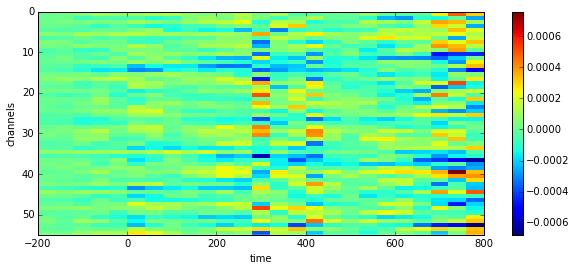

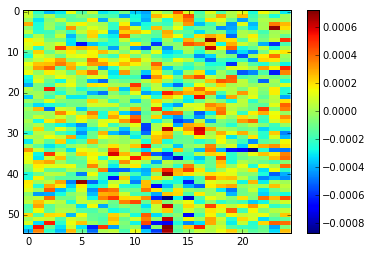

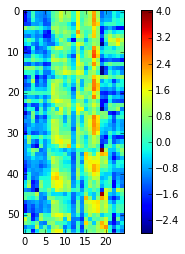

In [82]:
import theano
result_func = theano.function([model.get_input(train=False)], model.layers[-1].get_output(train=False)[:,1])
result_func_dense = theano.function([model_mlp.get_input(train=False)], model_mlp.layers[-1].get_output(train=False)[:,1])

# convolutions = convout1_f(reshaped[img_to_visualize: img_to_visualize+1])
# result_func.grad
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
from theano import tensor as T
grad_func = T.grad(model.layers[-1].get_output(train=False)[0,1], model.get_input(train=False) )
grad_func_dense = T.grad(model_mlp.layers[-1].get_output(train=False)[0,1], model_mlp.get_input(train=False) )

print result_func(stats.zscore(train_data, axis=1).astype('float32')[0].reshape(1,25,55)).shape
# print stats.zscore(shuffeled_samples[sss[0][0]], axis=1).astype('float32')[0].reshape(1,40,55).shape

dlogistic = theano.function([model.get_input(train=False)], grad_func)
dlogistic_dense = theano.function([model_mlp.get_input(train=False)], grad_func_dense)


sample_i = 43
data_to_diagnots =  stats.zscore(test_data_gcd, axis=1).astype('float32')[sample_i].reshape(1,25,55)

temp = dlogistic(data_to_diagnots)
temp.shape
plt.figure(figsize=(10,4)) 
ax = plt.gca()
plt.imshow(temp[0,:,:].T, interpolation='none',aspect='auto', extent=[-200,800,55,0])
# majorLocator = MultipleLocator(20)
# ax.xaxis.set_major_locator(majorLocator)
ax.set_xlabel('time') 
ax.set_ylabel('channels') 
plt.colorbar()
plt.show()

temp_dense = dlogistic_dense(data_to_diagnots)

plt.imshow(temp_dense[0,:,:].T, interpolation='none',aspect='auto')
plt.colorbar()
plt.show()

plt.imshow(data_to_diagnots[0,:,:].T, interpolation='none')
plt.colorbar()
plt.show()


In [76]:
def show_channel_plot(data, title):
    plt.figure(figsize=(10,4)) 
    ax = plt.gca()
    plt.imshow(data, interpolation='none',aspect='auto', extent=[-200,800,55,0])
    # majorLocator = MultipleLocator(20)
    # ax.xaxis.set_major_locator(majorLocator)
    ax.set_xlabel('time') 
    plt.title(title)
    ax.set_ylabel('channels') 
    plt.colorbar()
    plt.show()

[ 0.97060263]
[ 0.61991674]
0
0


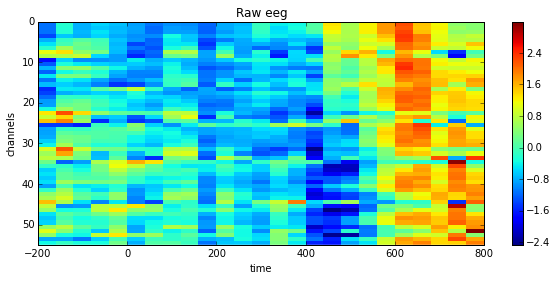

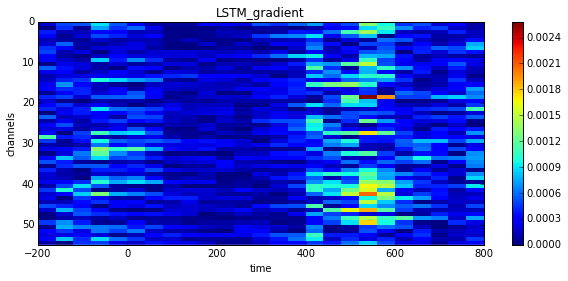

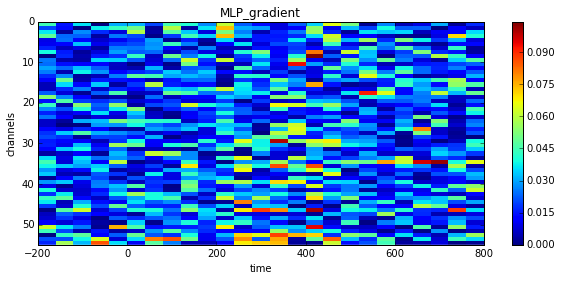

In [162]:
sample_i = 28

data_to_diagnots =  stats.zscore(test_data_gcd, axis=1).astype('float32')[sample_i].reshape(1,25,55)
print result_func(data_to_diagnots)
print result_func_dense(data_to_diagnots)
print test_target_gcd[sample_i]

print test_target_gcd[sample_i]
temp_dense = dlogistic_dense(data_to_diagnots)
show_channel_plot(data_to_diagnots[0,:,:].T, 'Raw eeg')

show_channel_plot(np.abs(dlogistic(data_to_diagnots)[0,:,:].T), 'LSTM_gradient')
show_channel_plot(np.abs(dlogistic_dense(data_to_diagnots)[0,:,:].T), 'MLP_gradient')

##average of gradient over the True

In [129]:
all_lstm_grad = np.zeros((55,25,len(np.where(test_target_gcd == 1)[0])))
all_dense_grad = np.zeros((55,25,len(np.where(test_target_gcd == 1)[0])))
# print np.abs(dlogistic(data_to_diagnots)[0,:,:].T).shape
for i, traget_i in  enumerate(np.where(test_target_gcd == 1)[0]):
    print i, traget_i
#     print stats.zscore(test_data_gcd, axis=1).astype('float32')[traget_i].shape
    data_to_diagnots =  stats.zscore(test_data_gcd, axis=1).astype('float32')[traget_i].reshape(1,25,55)
#     print np.abs(dlogistic(data_to_diagnots)[0,:,:].T).T.shape
#     print all_lstm_grad.shape
#     print all_lstm_grad[:,:,i].shape
    all_lstm_grad[:,:,i] = np.abs(dlogistic(data_to_diagnots)[0,:,:].T)
    all_dense_grad[:,:,i] = np.abs(dlogistic_dense(data_to_diagnots)[0,:,:].T)
#     print traget_i

0 29
1 49
2 79
3 119
4 144
5 164
6 199
7 224
8 269
9 299
10 306
11 346
12 366
13 401
14 446
15 461
16 491
17 521
18 566
19 581
20 623
21 638
22 688
23 713
24 738
25 753
26 808
27 818
28 843
29 883
30 912
31 937
32 972
33 1017
34 1037
35 1067
36 1102
37 1137
38 1152
39 1177
40 1205
41 1255
42 1265
43 1295
44 1320
45 1365
46 1400
47 1430
48 1440
49 1470
50 1509
51 1554
52 1579
53 1609
54 1639
55 1659
56 1709
57 1739
58 1759
59 1779
60 1811
61 1846
62 1881
63 1896
64 1931
65 1976
66 1996
67 2036
68 2051
69 2076
70 2100
71 2155
72 2165
73 2195
74 2230
75 2260
76 2295
77 2310
78 2360
79 2370
80 2412
81 2447
82 2472
83 2507
84 2547
85 2562
86 2592
87 2637
88 2652
89 2697
90 2708
91 2748
92 2773
93 2818
94 2843
95 2858
96 2908
97 2928
98 2958
99 2993
100 3020
101 3045
102 3085
103 3115
104 3145
105 3170
106 3190
107 3215
108 3240
109 3285
110 3318
111 3343
112 3373
113 3393
114 3443
115 3473
116 3483
117 3518
118 3558
119 3593
120 3602
121 3647
122 3687
123 3717
124 3747
125 3762
126 3792
127

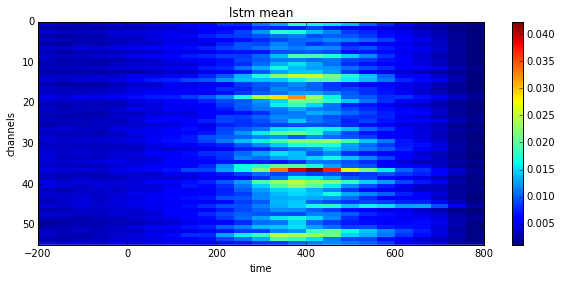

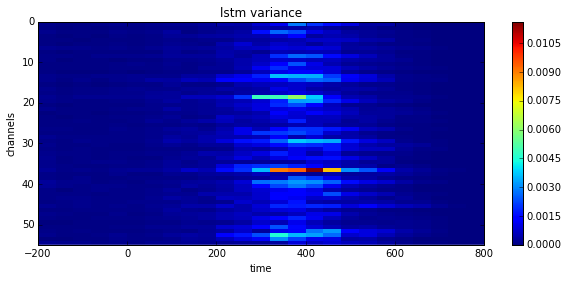

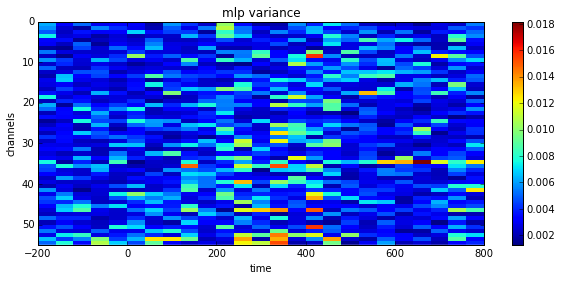

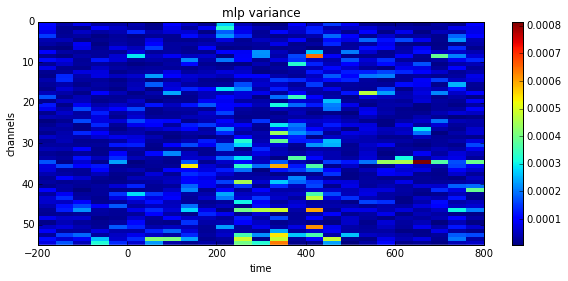

In [136]:
show_channel_plot(all_lstm_grad.mean(axis=2),'lstm mean')
show_channel_plot(all_lstm_grad.var(axis=2),'lstm variance')
show_channel_plot(all_dense_grad.mean(axis=2),'mlp variance')
show_channel_plot(all_dense_grad.var(axis=2),'mlp variance')



(11400L,)


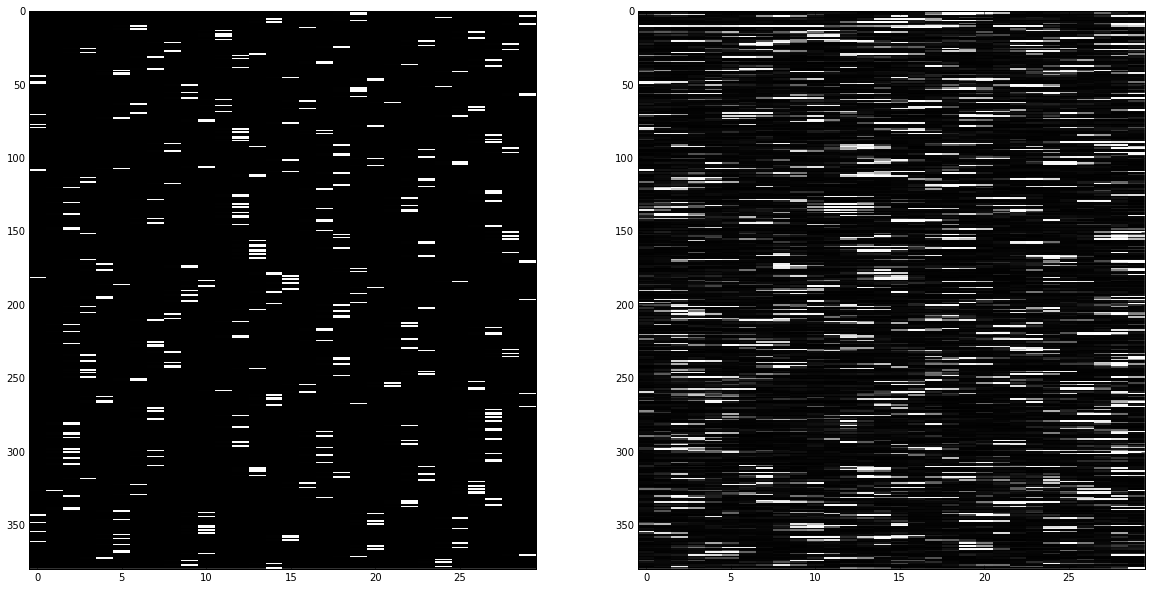

(380L, 11400L)
(11400L, 2L)
tp:224
tn:10259
t:380
fp:761
fn:156
f:11020


KeyboardInterrupt: 

In [78]:
target_location = np.where(np.all([gcd_res['train_mode'] != 1,gcd_res['target'] == 1 ], axis = 0))[0]
non_target_location = np.where(np.all([gcd_res['train_mode'] != 1 ], axis = 0))[0]
# np.abs(non_target_location - 13).argmin()
#         print target_location[0]
#         print len(target_location)
distance_from_target =  np.zeros((len(target_location), len(non_target_location)))
for i, item in enumerate(target_location) :
    distance_from_target[i,:] = non_target_location - item


minimal_distance_from_target = np.zeros_like(non_target_location)
for i, item in enumerate(np.abs(distance_from_target).argmin(axis=0).astype(np.int)) :
    minimal_distance_from_target[i] =  non_target_location[i] - target_location[item]


predicted_res = model.predict(stats.zscore(test_data_gcd, axis=1))
# print train_data.shape
print test_target_gcd.shape
print_true_vs_predict(to_categorical(test_target_gcd), predicted_res)
print distance_from_target.shape
print predicted_res.shape
print"tp:{0}".format( np.sum(np.all([test_target_gcd == 1,  predicted_res[:,1] >0.5], axis=0)))
print"tn:{0}".format( np.sum(np.all([test_target_gcd == 0,  predicted_res[:,1] <=0.5], axis=0)))
print"t:{0}".format( np.sum(np.all([test_target_gcd == 1], axis=0)))
print"fp:{0}".format( np.sum(np.all([test_target_gcd == 0,  predicted_res[:,1] >0.5], axis=0)))
print"fn:{0}".format( np.sum(np.all([test_target_gcd == 1,  predicted_res[:,1] <=0.5], axis=0)))
print"f:{0}".format( np.sum(np.all([test_target_gcd == 0], axis=0)))


sub_gcd_res = create_data_for_compare_by_repetition(file_name)
# sub_gcd_res = dict(train_trial=gcd_res['train_trial'][gcd_res['train_mode'] != 1],
# train_block=gcd_res['train_block'][gcd_res['train_mode'] != 1],
# stimulus=gcd_res['stimulus'][gcd_res['train_mode'] != 1])

_, _, gt_data_for_sum = create_target_table(sub_gcd_res, test_target_gcd)
_, _, actual_data_for_sum = create_target_table(sub_gcd_res, predicted_res[:, 1])
subject_results[i] = dict(test_prediction=test_prediction, 
                          auc_score=auc_score,
                          acc_by_rep=accuracy_by_repetition(actual_data_for_sum, gt_data_for_sum, number_of_repetition=10))

print "accuracy_by_repetition {0}".format(
    accuracy_by_repetition(actual_data_for_sum, gt_data_for_sum, number_of_repetition=10))



auc_score = roc_auc_score(test_target_gcd == 1, predicted_res[:,1])
print "auc_score:{0}".format(auc_score)


plt.scatter(minimal_distance_from_target, predicted_res[:,1],alpha=0.1)
hist_gaps = dict()
for gaps_i, gap in enumerate(range(-30,31)):
    hist_gaps[gaps_i] = predicted_res[:,1][minimal_distance_from_target == gap].sum()
print hist_gaps
plt.show()



predicted_res = model_mlp.predict(stats.zscore(test_data_gcd, axis=1))
# print train_data.shape
print test_target_gcd.shape
print_true_vs_predict(to_categorical(test_target_gcd), predicted_res)
print distance_from_target.shape
print predicted_res.shape
print"tp:{0}".format( np.sum(np.all([test_target_gcd == 1,  predicted_res[:,1] >0.5], axis=0)))
print"tn:{0}".format( np.sum(np.all([test_target_gcd == 0,  predicted_res[:,1] <=0.5], axis=0)))
print"t:{0}".format( np.sum(np.all([test_target_gcd == 1], axis=0)))
print"fp:{0}".format( np.sum(np.all([test_target_gcd == 0,  predicted_res[:,1] >0.5], axis=0)))
print"fn:{0}".format( np.sum(np.all([test_target_gcd == 1,  predicted_res[:,1] <=0.5], axis=0)))
print"f:{0}".format( np.sum(np.all([test_target_gcd == 0], axis=0)))

auc_score = roc_auc_score(test_target_gcd == 1, predicted_res[:,1])







sub_gcd_res = create_data_for_compare_by_repetition(file_name)
# sub_gcd_res = dict(train_trial=gcd_res['train_trial'][gcd_res['train_mode'] != 1],
# train_block=gcd_res['train_block'][gcd_res['train_mode'] != 1],
# stimulus=gcd_res['stimulus'][gcd_res['train_mode'] != 1])

_, _, gt_data_for_sum = create_target_table(sub_gcd_res, test_target_gcd)
_, _, actual_data_for_sum = create_target_table(sub_gcd_res, predicted_res[:, 1])
subject_results[i] = dict(test_prediction=test_prediction, 
                          auc_score=auc_score,
                          acc_by_rep=accuracy_by_repetition(actual_data_for_sum, gt_data_for_sum, number_of_repetition=10))

print "accuracy_by_repetition {0}".format(
    accuracy_by_repetition(actual_data_for_sum, gt_data_for_sum, number_of_repetition=10))



print "auc_score:{0}".format(auc_score)

plt.scatter(minimal_distance_from_target, predicted_res[:,1],alpha=0.1)
hist_gaps = dict()
for gaps_i, gap in enumerate(range(-30,31)):
    hist_gaps[gaps_i] = predicted_res[:,1][minimal_distance_from_target == gap].sum()
print hist_gaps
plt.show()